In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


In [2]:
# Parameters
epochs = 20
img_width, img_height = 224, 224
batch_size = 2
num_classes = 5
validation_split = 0.2
test_split = 0.1
data_dir = './../../datasets/dataset1' 


# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split + test_split
)

# Augmentation parameters for specific classes
specific_class_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split + test_split
)

# Generators for training and validation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split / (validation_split + test_split)
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data preparation for testing
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=test_split / (validation_split + test_split)
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Oversampling the specified minority classes with augmentation
specific_classes = ['1', '2', '3', '4']  # Example specific class indices as strings
oversample_ratio = 2  # How many times to oversample the specific classes

# Create separate generators for the specific classes with augmentation
specific_class_generators = []
for cls in specific_classes:
    specific_class_generator = specific_class_augmentation.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        classes=[cls],
        subset='training',
        shuffle=True
    )
    specific_class_generators.append(specific_class_generator)

# Function to combine generators
def combined_generator(base_generator, specific_class_generators, oversample_ratio):
    while True:
        x_batch, y_batch = base_generator.next()
        for _ in range(oversample_ratio):
            specific_class_index = np.random.randint(len(specific_class_generators))
            x_specific, y_specific = specific_class_generators[specific_class_index].next()
            
            # Ensure y_specific matches the shape of y_batch
            if y_specific.shape[1] == 1:
                y_specific = np.eye(num_classes)[y_specific[:, 0].astype(int)]  # One-hot encode if necessary
                
            x_batch = np.concatenate((x_batch, x_specific), axis=0)
            y_batch = np.concatenate((y_batch, y_specific), axis=0)
        
        yield x_batch, y_batch

# Combined generator for training
combined_train_generator = combined_generator(train_generator, specific_class_generators, oversample_ratio)



Tets
Found 24591 images belonging to 5 classes.
Found 23416 images belonging to 5 classes.
Found 11708 images belonging to 5 classes.
Found 1711 images belonging to 1 classes.
Found 3705 images belonging to 1 classes.
Found 612 images belonging to 1 classes.
Found 496 images belonging to 1 classes.


In [3]:
class_weights = compute_class_weight('balanced', classes=np.unique(test_generator.classes), y=test_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights: ", class_weights_dict)


Class weights:  {0: 0.27218412181797047, 1: 2.8766584766584766, 2: 1.327437641723356, 3: 8.046735395189003, 4: 9.922033898305084}


In [4]:
# Define a custom weighted categorical cross-entropy loss function
def weighted_categorical_crossentropy(weights):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        weights_tensor = tf.reduce_sum(weights * y_true, axis=-1)
        unweighted_losses = categorical_crossentropy(y_true, y_pred)
        weighted_losses = unweighted_losses * weights_tensor
        return tf.reduce_mean(weighted_losses)
    return loss

loss_fn = weighted_categorical_crossentropy(class_weights)

In [5]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

In [6]:
learning_rate = 3.9e-5
metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [7]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    
def show_confusion_matrix(model):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(conf_matrix)

    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, list(test_generator.class_indices.keys()))
    

In [8]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_fn, metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    combined_train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    batch_size=128
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

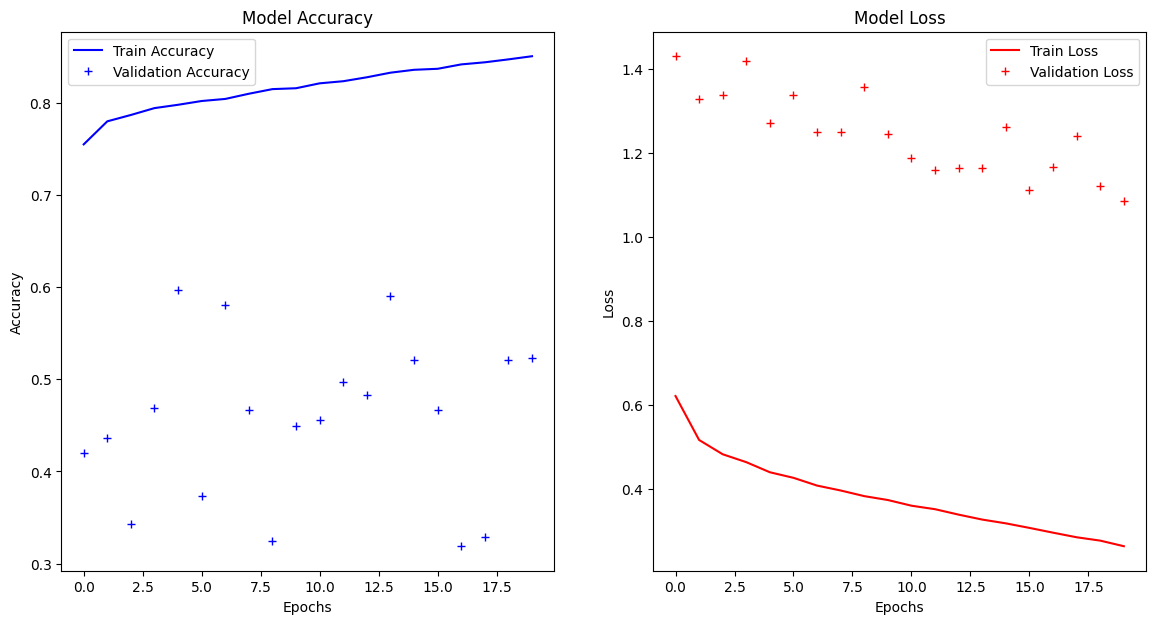

In [10]:
accuracyGraph(history)

5854/5854 [==============================] - 154s 26ms/step
              precision    recall  f1-score   support

           0       0.73      0.43      0.54      8603
           1       0.07      0.23      0.11       814
           2       0.14      0.22      0.17      1764
           3       0.02      0.05      0.03       291
           4       0.02      0.05      0.03       236

    accuracy                           0.37     11708
   macro avg       0.20      0.20      0.18     11708
weighted avg       0.57      0.37      0.43     11708

[[3693 1931 2034  540  405]
 [ 345  186  186   57   40]
 [ 772  410  390  110   82]
 [ 121   65   75   16   14]
 [ 106   59   49   11   11]]


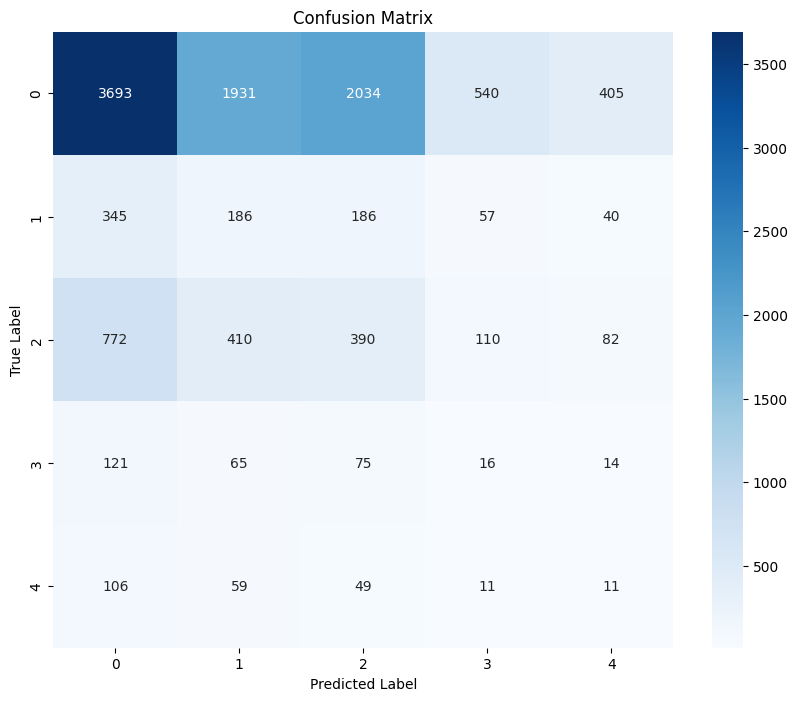

In [11]:
show_confusion_matrix(model)

In [12]:
_metrices = model.evaluate(test_generator)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

5854/5854 [==============================] - 190s 32ms/step - loss: 1.5013 - accuracy: 0.4717 - auc: 0.8108 - balanced_accuracy: 0.4717 - fscore: 0.3888 - precision: 0.5337 - recall: 0.2844
Test Metrices [1.5013123750686646, 0.47172874212265015, 0.8107702136039734, 0.47172874212265015, 0.3887966275215149, 0.5336538553237915, 0.284420907497406]


In [17]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in model.layers[:379]:  # Adjust the index as needed
    layer.trainable = False
for layer in model.layers[379:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss=loss_fn, metrics=metrics)

# Continue training (fine-tuning)
history = model.fit(
    combined_train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

Epoch 1/20


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12296/12296 [==============================] - 1195s 96ms/step - loss: 0.0843 - accuracy: 0.9795 - auc: 0.9880 - balanced_accuracy: 0.9656 - fscore: 0.9534 - precision: 0.9534 - recall: 0.9394 - val_loss: 1.2920 - val_accuracy: 0.8425 - val_auc: 0.9567 - val_balanced_accuracy: 0.8425 - val_fscore: 0.7984 - val_precision: 0.8541 - val_recall: 0.8341
Epoch 2/20
12296/12296 [==============================] - 1172s 95ms/step - loss: 0.0460 - accuracy: 0.9869 - auc: 0.9995 - balanced_accuracy: 0.9780 - fscore: 0.9694 - precision: 0.9884 - recall: 0.9858 - val_loss: 1.6582 - val_accuracy: 0.8112 - val_auc: 0.9418 - val_balanced_accuracy: 0.8112 - val_fscore: 0.7608 - val_precision: 0.8159 - val_recall: 0.8084
Epoch 3/20
12296/12296 [==============================] - 1190s 97ms/step - loss: 0.0395 - accuracy: 0.9867 - auc: 0.9995 - balanced_accuracy: 0.9777 - fscore: 0.9699 - precision: 0.9876 - recall: 0.9856 - val_loss: 1.5716 - val_accuracy: 0.8363 - val_auc: 0.9505 - val_balanced_accuracy

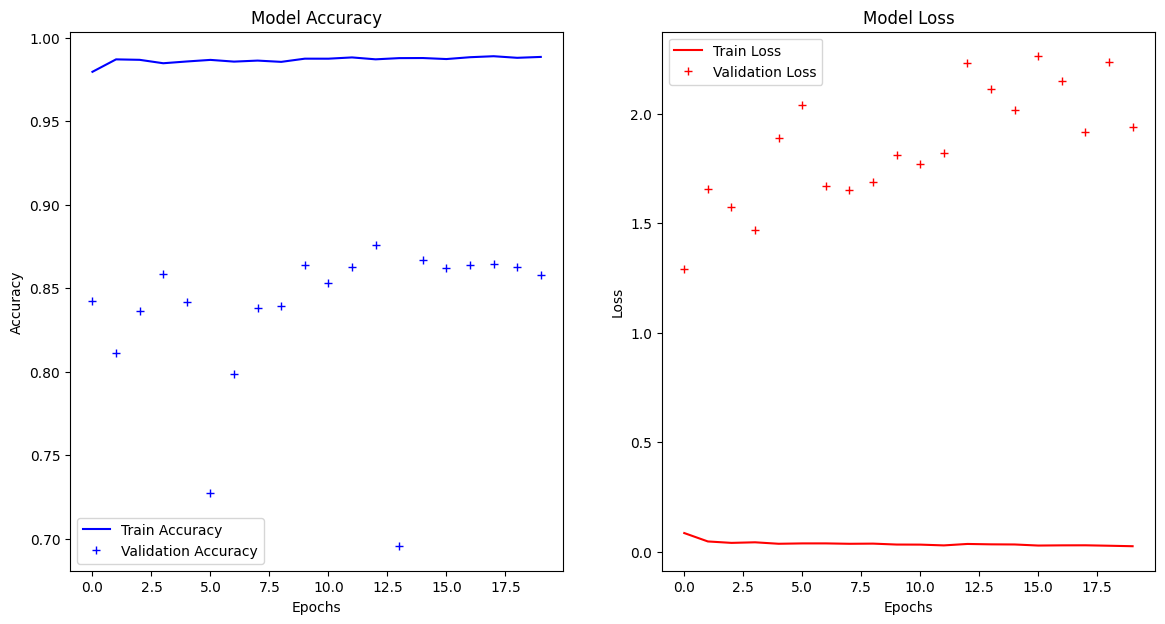

In [18]:
accuracyGraph(history)

5854/5854 [==============================] - 159s 27ms/step
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      8603
           1       0.07      0.07      0.07       814
           2       0.16      0.12      0.14      1764
           3       0.01      0.01      0.01       291
           4       0.02      0.02      0.02       236

    accuracy                           0.58     11708
   macro avg       0.20      0.20      0.20     11708
weighted avg       0.57      0.58      0.57     11708

[[6510  671  961  278  183]
 [ 634   61   80   23   16]
 [1352  135  208   38   31]
 [ 219   29   36    4    3]
 [ 173   17   32    9    5]]


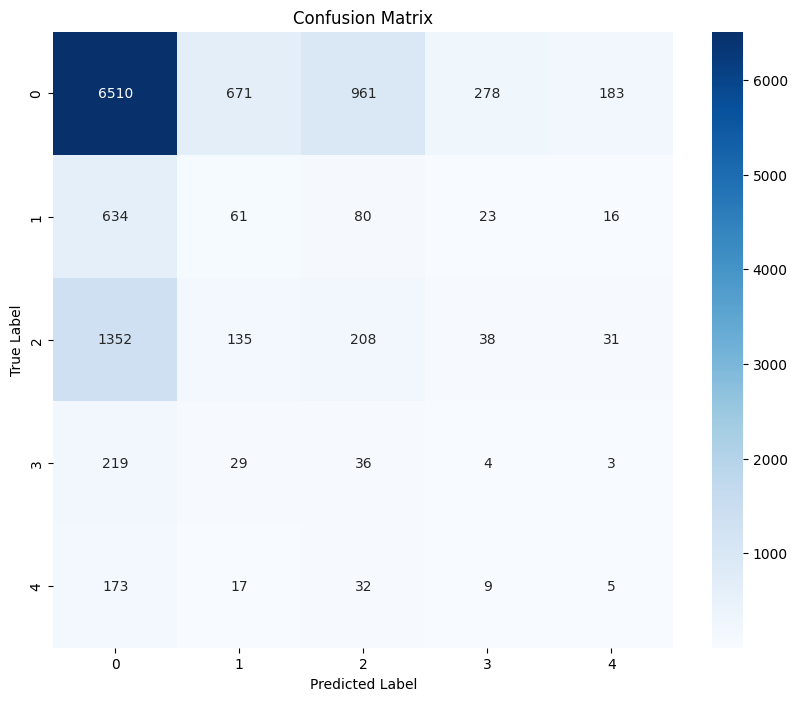

In [19]:
show_confusion_matrix(model)

In [20]:
_metrices = model.evaluate(test_generator)
print("Test Metrices", _metrices)

5854/5854 [==============================] - 185s 32ms/step - loss: 3.8473 - accuracy: 0.7293 - auc: 0.8979 - balanced_accuracy: 0.7293 - fscore: 0.6634 - precision: 0.7355 - recall: 0.7235
Test Metrices [3.8473093509674072, 0.7293303608894348, 0.8978796601295471, 0.7293303608894348, 0.6634094715118408, 0.7355213761329651, 0.7235223650932312]
